In [1]:
%run setup.ipynb
allel.__version__

'1.2.0'

In [2]:
#tbl_samples = phase2_ar1.tbl_samples ##remove once notebook pandas converted
df_samples = phase2_ar1.df_samples
callset_pass = phase2_ar1.callset_pass_biallelic
pop_colours = phase2_ar1.pop_colors
poppop_labels = phase2_ar1.pop_labels

In [3]:
populations = list(poppop_labels.keys())
populations.remove('colony')

I think we will struggle with the super small pops, I am going to remove them

In [4]:
populations.remove('GNcol')
populations.remove('GQgam')
populations.remove('GHgam')
populations

['AOcol',
 'BFcol',
 'GHcol',
 'CIcol',
 'GW',
 'GM',
 'GNgam',
 'BFgam',
 'CMgam',
 'UGgam',
 'GAgam',
 'FRgam',
 'KE']

In [5]:
#fix colours
pop_col = [pop_colours[p] for p in populations]

In [6]:
#fix labels
pop_labels = [poppop_labels[p] for p in populations]
pop_labels

['Angola $coluzzii$',
 'Burkina Faso $coluzzii$',
 'Ghana $coluzzii$',
 "Côte d'Ivoire $coluzzii$",
 'Guinea-Bissau',
 'The Gambia',
 'Guinea $gambiae$',
 'Burkina Faso $gambiae$',
 'Cameroon $gambiae$',
 'Uganda $gambiae$',
 'Gabon $gambiae$',
 'Mayotte $gambiae$',
 'Kenya']

In [7]:
popic = {}
count = 0
for p in populations:
    popic[p] = count
    count += 1

In [8]:
df_samples = df_samples.reset_index()
df_samples.head()

,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95033368,30.99
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95843804,31.70
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,107420666,35.65
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,95993752,29.46
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,103044262,33.67


in Alistair's phase 1 code, he subsets cameroon down, I don't think we need to do that again.

In [9]:
def load_tbl_samples_sub(chrom, subsets, seed):
    
    random.seed(seed)
    
    with section('compute subset sizes'):
        subset_sizes = [len(df_samples[df_samples.population == q]) for q in populations]
        n = min(subset_sizes)

    subsets_sidx = dict()
    for p in populations:
        subsets_sidx[p] = sorted(random.sample(list(df_samples[df_samples.population == p].index), n))

    sidx = list(itertools.chain(*subsets_sidx.values()))
    
    return sidx 

In [10]:
sidx = load_tbl_samples_sub('3R', populations, 42)

[compute subset sizes] begin
[compute subset sizes] done in a moment


In [11]:
def load_dbl_gn(chrom, sidx):
        
    with section('load and subset genotypes'):
        genotype = allel.GenotypeDaskArray(callset_pass[chrom]['calldata/genotype'])
        genotype_sub = genotype.take(sidx, axis=1)

    with section('count genotypes'):
        n_hom_alt = genotype_sub.count_hom_alt(axis=1).compute()
        
    with section('count alleles'):
        ac_sub = genotype_sub.count_alleles(max_allele=3).compute()

    with section('locate doubletons'):
        # use only ALT doubletons, ignore REF doubletons as very few
        loc_dbl = (ac_sub.max_allele() == 1) & (ac_sub[:, 1] == 2) & (n_hom_alt == 0)
    with section('compress genotypes to doubletons'):
        genotype_dbl = genotype_sub.compress(loc_dbl, axis=0)
        gn_dbl = genotype_dbl.to_n_alt().compute()

    return gn_dbl

In [12]:
df_samples_sub = df_samples.take(sidx)[['ox_code', 'population']]

In [13]:
df_samples_sub['subset_index'] = [popic[p] for p in list(df_samples_sub.population)]
df_samples_sub.reset_index(inplace=True)

In [14]:
def _dbl_count(x, y):
    return np.count_nonzero((x == 1) & (y == 1))

def count_pairwise_doubletons(chrom, subsets, seed):
    
    with section('subset samples'):
        sidx = load_tbl_samples_sub(chrom, subsets, seed)
    
    with section('load doubleton genotypes'):
        gn_dbl = load_dbl_gn(chrom, sidx)
    
    with section('count pairwise shared doubletons'):
        pairwise_dbl = allel.pairwise_distance(gn_dbl, _dbl_count, chunked=True)

    return pairwise_dbl#, gn_dbl, _dbl_count

In [15]:
pairwise_dbl_3R = count_pairwise_doubletons('3R', populations, seed=42)

[subset samples] begin
  [compute subset sizes] begin
  [compute subset sizes] done in a moment
[subset samples] done in a moment
[load doubleton genotypes] begin
  [load and subset genotypes] begin
  [load and subset genotypes] done in a moment
  [count genotypes] begin
  [count genotypes] done in 47 seconds
  [count alleles] begin
  [count alleles] done in 54 seconds
  [locate doubletons] begin
  [locate doubletons] done in a moment
  [compress genotypes to doubletons] begin
  [compress genotypes to doubletons] done in 38 seconds
[load doubleton genotypes] done in 2 minutes
[count pairwise shared doubletons] begin
[count pairwise shared doubletons] done in a minute


In [16]:
pairwise_dbl_3L = count_pairwise_doubletons('3L', populations, seed=42)

[subset samples] begin
  [compute subset sizes] begin
  [compute subset sizes] done in a moment
[subset samples] done in a moment
[load doubleton genotypes] begin
  [load and subset genotypes] begin
  [load and subset genotypes] done in a moment
  [count genotypes] begin
  [count genotypes] done in 31 seconds
  [count alleles] begin
  [count alleles] done in 38 seconds
  [locate doubletons] begin
  [locate doubletons] done in a moment
  [compress genotypes to doubletons] begin
  [compress genotypes to doubletons] done in 28 seconds
[load doubleton genotypes] done in a minute
[count pairwise shared doubletons] begin
[count pairwise shared doubletons] done in 52 seconds


In [17]:
pairwise_dbl_3L.shape

(48516,)

In [18]:
np.count_nonzero(pairwise_dbl_3L)

37154

In [19]:
np.count_nonzero(pairwise_dbl_3R)

38654

## main figure

In [20]:
def plot_pw_dbl_sub(pairwise_dbl, populations, pop_col, pop_labels, df_samples_sub, fig=None):
    assert len(populations) == len(pop_col)
    
    n = df_samples_sub.shape[0]
    yy = list()
    ee = list()
    for subset_id1 in populations:
        pop1 = list(df_samples_sub[df_samples_sub.population == subset_id1].index)
        y = list()
        e = list()
        for subset_id2 in populations:
            if subset_id1 != subset_id2:
                pop2 = list(df_samples_sub[df_samples_sub.population == subset_id2].index)
                pidx = allel.condensed_coords_between(pop1, pop2, n)
            else:
                pidx = allel.condensed_coords_within(pop1, n)
            d = pairwise_dbl.take(pidx)
            y.append(np.mean(d))
            e.append(scipy.stats.sem(d))
        yy.append(y)
        ee.append(e)
    yy = np.array(yy)
    ee = np.array(ee)

    # yy is number of doubletons shared
    if fig is None:
        fig = plt.figure(figsize=(1 + .3*len(populations), 1 + .3*len(populations)))
        
    gs = GridSpec(len(populations), 2, width_ratios=(9, 1))
    
    for i1 in range(len(populations)):    
        ax = fig.add_subplot(gs[i1, 0])
        sns.despine(ax=ax, left=True, bottom=True, top=True)
        p1 = pop_labels[i1]
        y = yy[i1]
        e = ee[i1]
        ax.bar(np.arange(len(populations)) + .05, y, width=.9, color=pop_col, lw=0)
        ax.set_xlim(0, len(populations))
        ax.set_xticks([])
        ax.set_ylabel(p1, fontweight='bold', color="#2b2b2b", rotation=0, ha='right', va='center')
        ymax = np.sum(y)
        ax.set_ylim(0, ymax)
        ax.set_yticks([])
        if i1 == 0:
            for i in range(len(populations)):
                ax.text((i+.4)/len(populations), 1.1, pop_labels[i], color=pop_col[i], transform=ax.transAxes, rotation=45,
                        ha='left', va='bottom', fontweight='bold')
    
            # add f2 label
            ax.text(x=(i+1.9)/len(populations), y=1.1, s='$f_{2}$ variants', 
                    color="#525252", transform=ax.transAxes, rotation=45,
                    ha='left', va='bottom', fontweight='bold')
            
    # define upper limit of right hand bar plot
    maxsum = yy.sum(axis=1).max() * 1.05
    ceiling = np.ceil(maxsum/10) * 10
    
    for i1 in range(len(populations)):    
        
        ax2 = fig.add_subplot(gs[i1, 1])
        y = yy[i1]            
        #ax2 = fig.add_subplot(gs[:, 1])
        ax2.barh([0.5], [np.sum(y)], color='#525252', align="center", height=0.8)
        ax2.set_xlim((0, ceiling))
        
        #if i1 == (len(subsets) -1):
        if False:
            sns.despine(ax=ax2, left=True, bottom=False, top=True)
            ax2.set_xticks((0, ceiling))
        else:
            sns.despine(ax=ax2, left=True, bottom=True, top=True)
            ax2.set_xticks([])
        
        ax2.set_yticks([])
#             ax.tick_params(length=0)
#             ax.xaxis.tick_top()
#             ax.set_xticklabels(subset_labels, rotation=45, ha='left')

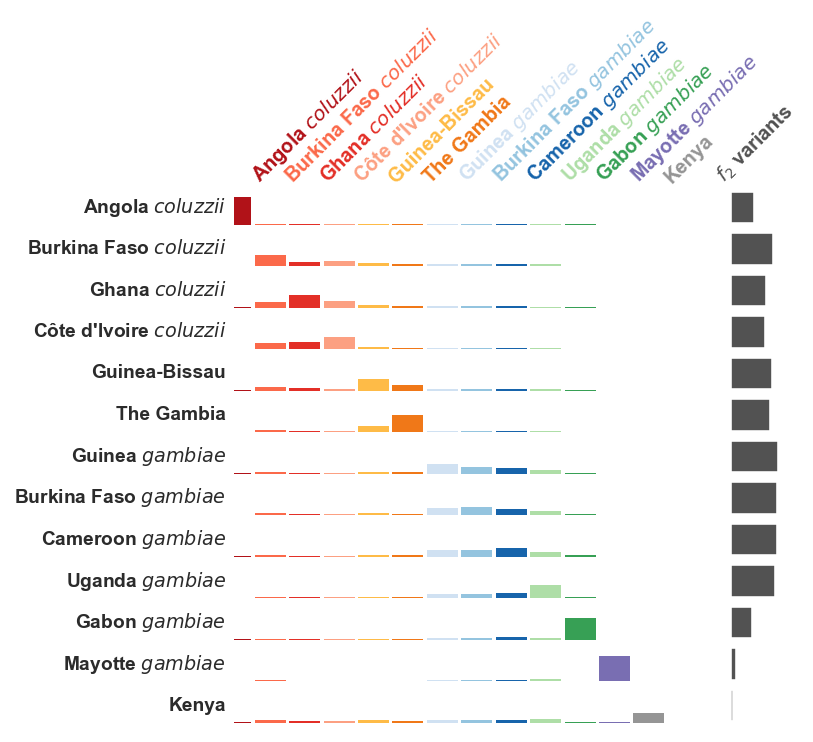

In [21]:
plot_pw_dbl_sub(pairwise_dbl_3L + pairwise_dbl_3R, 
                populations, pop_col, pop_labels, df_samples_sub)

In [22]:
def fig_pop_dbl(figsize=(2.2, 2.5), fn=None, dpi=600):
    fig = plt.figure(figsize=figsize)
    plot_pw_dbl_sub(pairwise_dbl_3L + pairwise_dbl_3R, 
                    populations, pop_col, pop_labels, df_samples_sub, fig=fig)
    ax = fig.axes[0]
    #ax.text(-0.3, 3, '\\textbf{c}', ha='left', va='top', transform=ax.transAxes, fontsize=10)

    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')

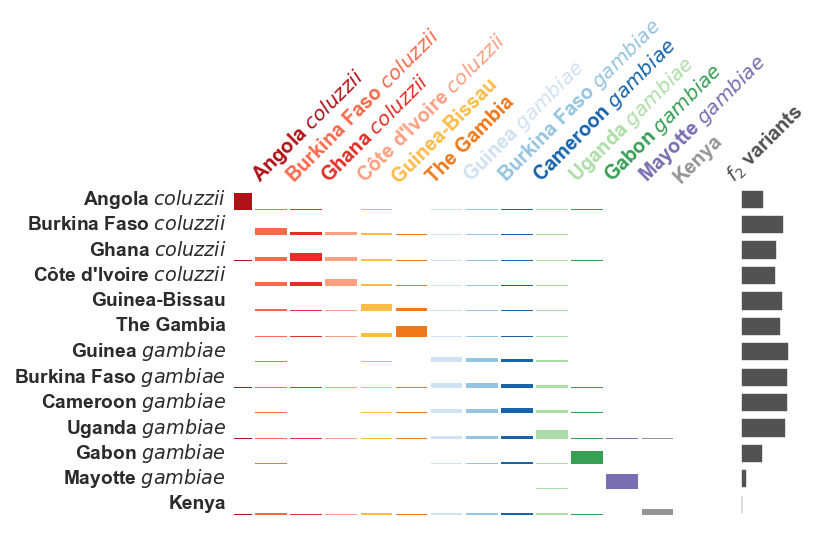

In [23]:
fig_pop_dbl(figsize=(5, 3), 
            fn='../artwork/doubletons.jpeg', 
            dpi=900)

In [24]:
def plot_pw_dbl_sub_nof2(pairwise_dbl, populations, pop_col, pop_labels, df_samples_sub, fig=None):
    assert len(populations) == len(pop_col)
    
    n = df_samples_sub.shape[0]
    yy = list()
    ee = list()
    for subset_id1 in populations:
        pop1 = list(df_samples_sub[df_samples_sub.population == subset_id1].index)
        y = list()
        e = list()
        for subset_id2 in populations:
            if subset_id1 != subset_id2:
                pop2 = list(df_samples_sub[df_samples_sub.population == subset_id2].index)
                pidx = allel.condensed_coords_between(pop1, pop2, n)
            else:
                pidx = allel.condensed_coords_within(pop1, n)
            d = pairwise_dbl.take(pidx)
            y.append(np.mean(d))
            e.append(scipy.stats.sem(d))
        yy.append(y)
        ee.append(e)
    yy = np.array(yy)
    ee = np.array(ee)

    # yy is number of doubletons shared
    if fig is None:
        fig = plt.figure(figsize=(1 + .3*len(populations), 1 + .3*len(populations)))
        
    gs = GridSpec(len(populations), 2, width_ratios=(9, 1))
    
    for i1 in range(len(populations)):    
        ax = fig.add_subplot(gs[i1, 0])
        sns.despine(ax=ax, left=True, bottom=True, top=True)
        p1 = pop_labels[i1]
        y = yy[i1]
        e = ee[i1]
        ax.bar(np.arange(len(populations)) + .05, y, width=.9, color=pop_col, lw=0)
        ax.set_xlim(0, len(populations))
        ax.set_xticks([])
        ax.set_ylabel(p1, fontweight='bold', color="#2b2b2b", rotation=0, ha='right', va='center')
        ymax = np.sum(y)
        ax.set_ylim(0, ymax)
        ax.set_yticks([])
        if i1 == 0:
            for i in range(len(populations)):
                ax.text((i+.4)/len(populations), 1.1, pop_labels[i], color=pop_col[i], transform=ax.transAxes, rotation=45,
                        ha='left', va='bottom', fontweight='bold')
    
#             # add f2 label
#             ax.text(x=(i+1.9)/len(populations), y=1.1, s='$f_{2}$ variants', 
#                     color="#525252", transform=ax.transAxes, rotation=45,
#                     ha='left', va='bottom', fontweight='bold')
            
#     # define upper limit of right hand bar plot
#     maxsum = yy.sum(axis=1).max() * 1.05
#     ceiling = np.ceil(maxsum/10) * 10
    
#     for i1 in range(len(populations)):    
        
#         ax2 = fig.add_subplot(gs[i1, 1])
#         y = yy[i1]            
#         #ax2 = fig.add_subplot(gs[:, 1])
#         ax2.barh([0.5], [np.sum(y)], color='#525252', align="center", height=0.8)
#         ax2.set_xlim((0, ceiling))
        
#         #if i1 == (len(subsets) -1):
#         if False:
#             sns.despine(ax=ax2, left=True, bottom=False, top=True)
#             ax2.set_xticks((0, ceiling))
#         else:
#             sns.despine(ax=ax2, left=True, bottom=True, top=True)
#             ax2.set_xticks([])
        
#         ax2.set_yticks([])
# #             ax.tick_params(length=0)
# #             ax.xaxis.tick_top()
# #             ax.set_xticklabels(subset_labels, rotation=45, ha='left')

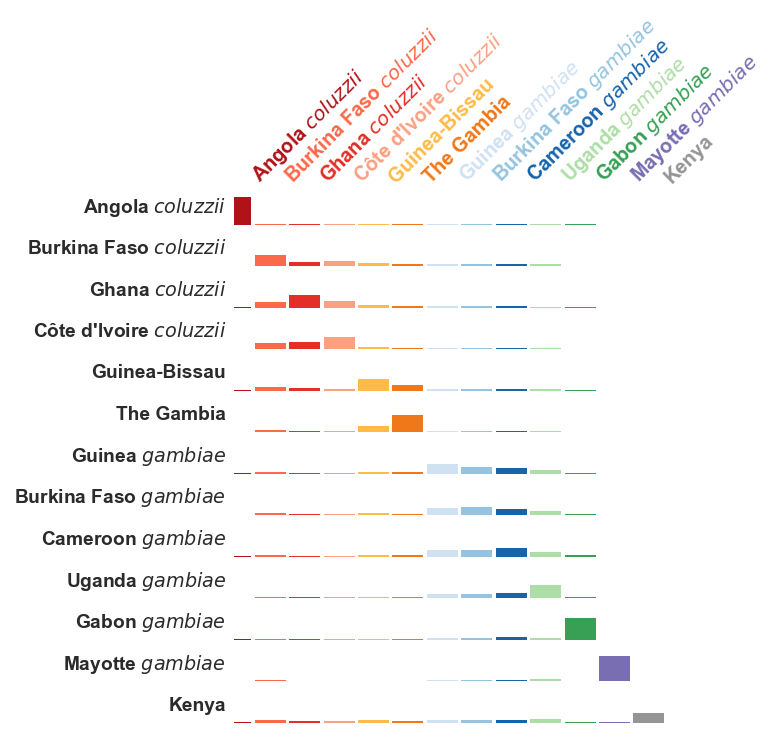

In [25]:
plot_pw_dbl_sub_nof2(pairwise_dbl_3L + pairwise_dbl_3R, 
                populations, pop_col, pop_labels, df_samples_sub)

In [27]:
def fig_pop_dbl_nof2(figsize=(2.2, 2.5), fn=None, dpi=600):
    fig = plt.figure(figsize=figsize)
    plot_pw_dbl_sub_nof2(pairwise_dbl_3L + pairwise_dbl_3R, 
                    populations, pop_col, pop_labels, df_samples_sub, fig=fig)
    ax = fig.axes[0]
    #ax.text(-0.3, 3, '\\textbf{c}', ha='left', va='top', transform=ax.transAxes, fontsize=10)

    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')

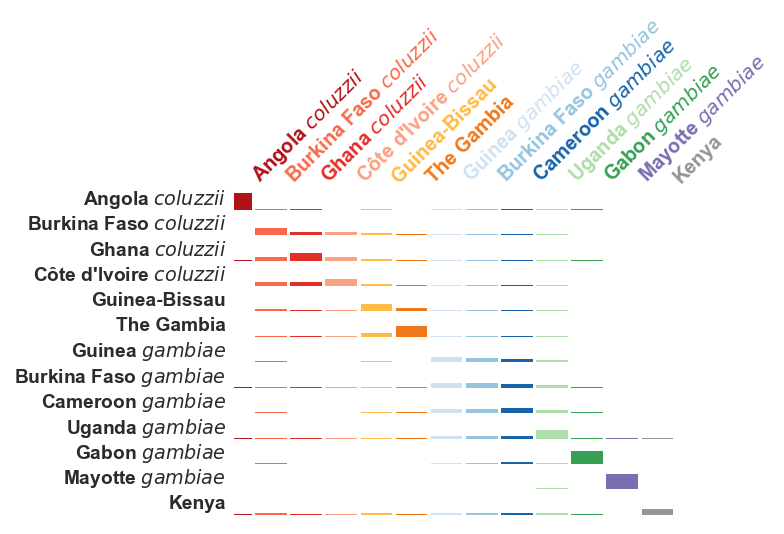

In [29]:
fig_pop_dbl_nof2(figsize=(5, 3), 
            fn='../artwork/doubletons_nof2.jpeg', 
            dpi=900)